## Task 1
`predictive_maintenance_dataset.csv` is a file that contains parameters and settings (`operational_setting_1`, `operational_setting_2`, `sensor_measurement_1`, `sensor_measurement_2`, etc.) for many wind turbines. There is a column called `unit_number` which specifies which turbine it is, and one called `status`, in which a value of 1 means the turbine broke down that day, and 0 means it didn't. Your task is to create a model that, when fed with operational settings and sensor measurements (`unit_number` and `time_stamp` will *not* be fed in), outputs 1 if the turbine will break down within the next 40 days, and 0 if not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Data preprocessing
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split

In [4]:
# Evaluation metrics
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score


In [5]:
# Classification models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [6]:
# Libraries for hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV

In [7]:
# Libraries for feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [8]:
# To save the final model
import pickle

In [13]:
clf_data = pd.read_csv("predictive_maintenance_dataset_40days.csv")

In [14]:
clf_data.shape

(118883, 27)

In [15]:
clf_data.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,540,2016-05-01T12:00:00Z,0,42.0033,0.8400,High,445.00,549.11,1345.86,1123.35,...,130.38,2387.98,8075.70,9.3392,0.02,327.0,2212.0,100.00,10.59,6.4311
1,540,2016-05-02T12:00:00Z,0,10.0049,0.2513,High,489.05,604.12,1497.52,1299.13,...,371.99,2387.94,8126.65,8.5735,0.03,367.0,2319.0,100.00,28.54,17.2279
2,540,2016-05-03T12:00:00Z,0,20.0026,0.7011,High,491.19,606.99,1480.01,NaN,...,314.99,2387.97,8061.05,9.1776,0.02,364.0,2324.0,100.00,24.40,14.7659
3,540,2016-05-04T12:00:00Z,0,42.0023,0.8409,High,445.00,549.09,1346.29,1119.90,...,130.64,2387.98,8080.58,9.3504,0.02,NaN,NaN,100.00,10.74,6.2972
4,540,2016-05-05T12:00:00Z,0,25.0031,0.6200,NaN,462.54,536.18,1260.24,1038.22,...,164.24,2028.22,7866.67,10.8344,0.02,307.0,1915.0,84.93,14.34,8.5780


In [16]:
clf_data['operational_setting_3'].head()

0    High
1    High
2    High
3    High
4     NaN
Name: operational_setting_3, dtype: object

In [17]:
clf_data['operational_setting_3'].map( {'High':1, 'Low':0} ).head()

0    1.0
1    1.0
2    1.0
3    1.0
4    NaN
Name: operational_setting_3, dtype: float64

In [18]:
clf_data['operational_setting_3'].map( {'High':1, 'Low':0} ).unique()

array([  1.,  nan,   0.])

In [19]:
clf_data['os3_binary'] = clf_data['operational_setting_3'].map( {'High':1, 'Low':0} )

In [20]:
clf_data.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,os3_binary
0,540,2016-05-01T12:00:00Z,0,42.0033,0.8400,High,445.00,549.11,1345.86,1123.35,...,2387.98,8075.70,9.3392,0.02,327.0,2212.0,100.00,10.59,6.4311,1.0
1,540,2016-05-02T12:00:00Z,0,10.0049,0.2513,High,489.05,604.12,1497.52,1299.13,...,2387.94,8126.65,8.5735,0.03,367.0,2319.0,100.00,28.54,17.2279,1.0
2,540,2016-05-03T12:00:00Z,0,20.0026,0.7011,High,491.19,606.99,1480.01,NaN,...,2387.97,8061.05,9.1776,0.02,364.0,2324.0,100.00,24.40,14.7659,1.0
3,540,2016-05-04T12:00:00Z,0,42.0023,0.8409,High,445.00,549.09,1346.29,1119.90,...,2387.98,8080.58,9.3504,0.02,NaN,NaN,100.00,10.74,6.2972,1.0
4,540,2016-05-05T12:00:00Z,0,25.0031,0.6200,NaN,462.54,536.18,1260.24,1038.22,...,2028.22,7866.67,10.8344,0.02,307.0,1915.0,84.93,14.34,8.5780,NaN


In [21]:
X = clf_data.drop(['time_stamp', 'unit_number','status', 'operational_setting_3'], axis=1)

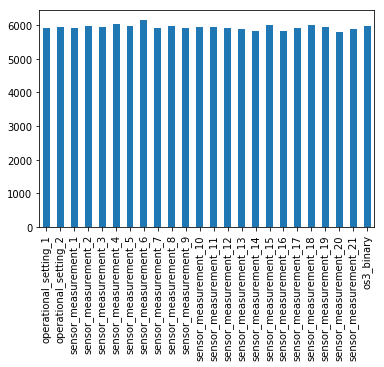

In [22]:
X.isnull().sum().plot(kind='bar')

In [23]:
# Imputing missing values in categorical variables
data_imputer = Imputer(strategy='most_frequent')
X['os3_binary'] = data_imputer.fit_transform(X['os3_binary'].reshape(-1,1))

/Users/avinash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# Checking the unique values for os3
X['os3_binary'].unique()

array([ 1.,  0.])

In [25]:
data_imputer = Imputer()
X_imp = data_imputer.fit_transform(X)

In [26]:
X_imp = pd.DataFrame(X_imp, columns=X.columns)

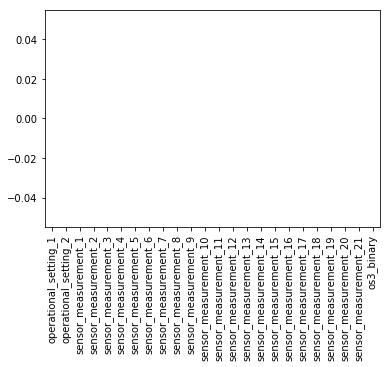

In [27]:
X_imp.isnull().sum().plot(kind='bar')

In [28]:
y = clf_data['status']

In [29]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.15, random_state=7)

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=7)

In [31]:
def evaluate(model):
    print("-----Training-----", "\n")
    # Accuracy
    train_score = model.score(X_train, y_train)
    print("Train Accuracy: ", train_score)
    # Recall Score
    train_recall = recall_score(y_pred = model.predict(X_train), y_true=y_train)
    print("Train Recall: ", train_recall)
    # Confusion Matrix
    print("Train Confusion Matrix")
    cm_train = pd.DataFrame(confusion_matrix(y_pred = model.predict(X_train), y_true=y_train))
    print(cm_train, "\n")
    
    print("-----Validation-----", "\n")
    # Accuracy
    val_score = model.score(X_val, y_val)
    print("Test Accuracy: ", val_score)
    # Recall Scores
    val_recall = recall_score(y_pred = model.predict(X_val), y_true=y_val)
    print("Test Recall: ", val_recall)
    # Confusion Matrix
    print("Test Confusion Matrix")
    cm_val = pd.DataFrame(confusion_matrix(y_pred = model.predict(X_val), y_true=y_val))
    print(cm_val)

def evaluate_test(model):
    print("-----Testing-----", "\n")
    # Accuracy
    test_score = model.score(X_test, y_test)
    print("Train Accuracy: ", test_score)
    # Recall Score
    test_recall = recall_score(y_pred = model.predict(X_test), y_true=y_test)
    print("Test Recall: ", test_recall)
    # Confusion Matrix
    print("Test Confusion Matrix")
    cm_test = pd.DataFrame(confusion_matrix(y_pred = model.predict(X_test), y_true=y_test))
    print(cm_test, "\n")

## Using Logistic Regression

In [32]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
evaluate(lr_clf)

-----Training----- 

Train Accuracy:  0.99480743259
Train Recall:  0.0
Train Confusion Matrix
       0  1
0  85446  0
1    446  0 

-----Validation----- 

Test Accuracy:  0.994326428289
Test Recall:  0.0
Test Confusion Matrix
       0  1
0  15072  0
1     86  0


## Using SGD

In [34]:
sgd_clf = SGDClassifier(penalty="l1")
sgd_clf.fit(X_train, y_train)

/Users/avinash/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [35]:
evaluate(sgd_clf)

-----Training----- 

Train Accuracy:  0.99480743259
Train Recall:  0.0
Train Confusion Matrix
       0  1
0  85446  0
1    446  0 

-----Validation----- 

Test Accuracy:  0.994326428289
Test Recall:  0.0
Test Confusion Matrix
       0  1
0  15072  0
1     86  0


## Using Random Forest

In [36]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
evaluate(rf_clf)

-----Training----- 

Train Accuracy:  0.998719321939
Train Recall:  0.7533632287
Train Confusion Matrix
       0    1
0  85446    0
1    110  336 

-----Validation----- 

Test Accuracy:  0.994326428289
Test Recall:  0.0
Test Confusion Matrix
       0  1
0  15072  0
1     86  0


## XGBoost

In [38]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [39]:
evaluate(xgb)

-----Training----- 

Train Accuracy:  0.994830717645
Train Recall:  0.0067264573991
Train Confusion Matrix
       0  1
0  85445  1
1    443  3 

-----Validation----- 

Test Accuracy:  0.994326428289
Test Recall:  0.0
Test Confusion Matrix
       0  1
0  15072  0
1     86  0


# GradientBoostingClassifier

In [40]:
gbc_clf = GradientBoostingClassifier()
gbc_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [41]:
evaluate(gbc_clf)

-----Training----- 

Train Accuracy:  0.995354631398
Train Recall:  0.12331838565
Train Confusion Matrix
       0   1
0  85438   8
1    391  55 

-----Validation----- 

Test Accuracy:  0.99386462594
Test Recall:  0.0116279069767
Test Confusion Matrix
       0  1
0  15064  8
1     85  1


## Hyper Parameter Optimization for GradientBoostingClassifier

In [42]:
parameters = {'learning_rate' : np.logspace(-2,0,num=3),
              'n_estimators': [100, 200, 250], 
              'max_depth':[3,5,7], 
              'max_features': ['auto', 'sqrt']}

In [43]:
gbc = GradientBoostingClassifier()
opt_gbc = RandomizedSearchCV(gbc, parameters, n_jobs = -1, scoring= 'recall', n_iter=9)
opt_gbc.fit(X_train,y_train)
print(opt_gbc.best_params_)
print("Accuracy:", opt_gbc.best_score_)
print("Error:", 1- opt_gbc.best_score_)

{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 1.0}
Accuracy: 0.291327357269
Error: 0.708672642731


In [46]:
gbc_clf = GradientBoostingClassifier(n_estimators = 200, max_depth = 7, learning_rate = 1)
gbc_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [47]:
evaluate(gbc_clf)

-----Training----- 

Train Accuracy:  0.992327574163
Train Recall:  0.495515695067
Train Confusion Matrix
       0    1
0  85012  434
1    225  221 

-----Validation----- 

Test Accuracy:  0.987069534239
Test Recall:  0.0813953488372
Test Confusion Matrix
       0    1
0  14955  117
1     79    7


## Feature Selection 

#### Using Extra trees classifier and L1 for feature selection

In [48]:
clf_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=250, random_state=7))),
  ('classification', GradientBoostingClassifier(n_estimators = 200, max_depth = 7, learning_rate = 1))
])
clf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_sam...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [49]:
evaluate(clf_pipeline)

-----Training----- 

Train Accuracy:  0.986331672333
Train Recall:  0.423766816143
Train Confusion Matrix
       0    1
0  84529  917
1    257  189 

-----Validation----- 

Test Accuracy:  0.981857764877
Test Recall:  0.0813953488372
Test Confusion Matrix
       0    1
0  14876  196
1     79    7


#### Using LinearSVC and L1 for feature selection

In [50]:
svc_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual = False))),
  ('classification', GradientBoostingClassifier(n_estimators = 200, max_depth = 7, learning_rate = 1))
])
svc_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
        norm_order=1, prefit...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [51]:
evaluate(svc_pipeline)

-----Training----- 

Train Accuracy:  0.994993713035
Train Recall:  0.237668161435
Train Confusion Matrix
       0    1
0  85356   90
1    340  106 

-----Validation----- 

Test Accuracy:  0.991291727141
Test Recall:  0.0348837209302
Test Confusion Matrix
       0   1
0  15023  49
1     83   3


#### Using Logistic Regression and L1 for feature selection

In [52]:
lr_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1"))),
  ('classification', GradientBoostingClassifier(n_estimators = 200, max_depth = 7, learning_rate = 1))
])
lr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [53]:
evaluate(lr_pipeline)

-----Training----- 

Train Accuracy:  0.990266846738
Train Recall:  0.242152466368
Train Confusion Matrix
       0    1
0  84948  498
1    338  108 

-----Validation----- 

Test Accuracy:  0.987597308352
Test Recall:  0.0581395348837
Test Confusion Matrix
       0    1
0  14965  107
1     81    5


# Test scores for the final model

In [54]:
evaluate_test(clf_pipeline)

-----Testing----- 

Train Accuracy:  0.981943587731
Test Recall:  0.118811881188
Test Confusion Matrix
       0    1
0  17499  233
1     89   12 



In [55]:
roc_auc_score(y_score=clf_pipeline.predict(X_train), y_true=y_train)

0.7065174459436212

## Saving final model

In [56]:
save_classifier = open("task1v2_model.pickle", "wb")
pickle.dump(clf_pipeline, save_classifier)
save_classifier.close()

# Experimenting with Imbalanced-learn

In [57]:
from imblearn import over_sampling as os

In [60]:
from imblearn import pipeline as pl

In [61]:
pipeline = pl.make_pipeline(os.SMOTE(random_state=7),
                            GradientBoostingClassifier(n_estimators = 200, max_depth = 7, learning_rate = 1))

In [62]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=7, ratio='auto', svm_estimator=None)), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='dev...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [63]:
evaluate(pipeline)

-----Training----- 

Train Accuracy:  0.999988357472
Train Recall:  1.0
Train Confusion Matrix
       0    1
0  85445    1
1      0  446 

-----Validation----- 

Test Accuracy:  0.991621585961
Test Recall:  0.0348837209302
Test Confusion Matrix
       0   1
0  15028  44
1     83   3


In [65]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_sample(X_imp, y)

In [ ]:
X_resampledsampled.shape

In [66]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=7)

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=7)

In [67]:
lr_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1"))),
  ('classification', GradientBoostingClassifier(n_estimators = 200, max_depth = 7, learning_rate = 1))
])
lr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [68]:
evaluate(lr_pipeline)

-----Training----- 

Train Accuracy:  0.999982442896
Train Recall:  1.0
Train Confusion Matrix
       0      1
0  85517      3
1      0  85351 

-----Validation----- 

Test Accuracy:  0.995556145122
Test Recall:  0.99621965778
Test Confusion Matrix
       0      1
0  14999     77
1     57  15021


# Design Decisions for Task 1

1. Encode the categorical variables using MAP as sklearn cannot handle categorical variables.
2. Impute the missing categorical and continuous variables using sklearn Imputer as sklearn cannot handle missing values.
3. Use sklearn train_test_split to divide the data into train, validation and test to ensure to there is overfitting and to avoid optimization bias.
4. Try different classification models & identify the best performing model.
5. Perform hyperparameter optimzation to tune the best performing model. The best model was selected for task1 is GradientBoostingClassifier.
6. Perform feature selection using the optimized model and sklearn pipeline.
